In [32]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

# Reading Data

In [2]:
# Reading data
df = pd.read_csv(r'Data\HI-Medium_Trans.csv')

df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:17,20,800104D70,20,800104D70,6794.63,US Dollar,6794.63,US Dollar,Reinvestment,0
1,2022/09/01 00:02,3196,800107150,3196,800107150,7739.29,US Dollar,7739.29,US Dollar,Reinvestment,0
2,2022/09/01 00:17,1208,80010E430,1208,80010E430,1880.23,US Dollar,1880.23,US Dollar,Reinvestment,0
3,2022/09/01 00:03,1208,80010E650,20,80010E6F0,73966883.00,US Dollar,73966883.00,US Dollar,Cheque,0
4,2022/09/01 00:02,1208,80010E650,20,80010EA30,45868454.00,US Dollar,45868454.00,US Dollar,Cheque,0


# EDA

In [3]:
# Droping all duplicated data points
df = df.drop_duplicates()

In [4]:
df.describe()

,From Bank,To Bank,Amount Received,Amount Paid,Is Laundering
count,3.189822e+07,3.189822e+07,3.189822e+07,3.189822e+07,3.189822e+07
mean,2.944094e+05,4.093194e+05,6.431120e+06,4.417554e+06,1.104450e-03
std,6.153148e+05,6.546999e+05,2.592745e+09,1.848314e+09,3.321492e-02
min,0.000000e+00,0.000000e+00,1.000000e-06,1.000000e-06,0.000000e+00
25%,2.954000e+03,2.749600e+04,2.078700e+02,2.092300e+02,0.000000e+00
50%,3.902400e+04,1.468530e+05,1.469260e+03,1.471540e+03,0.000000e+00
75%,2.158840e+05,2.598930e+05,1.183530e+04,1.175781e+04,0.000000e+00
max,3.225455e+06,3.225455e+06,8.158609e+12,8.158609e+12,1.000000e+00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31898218 entries, 0 to 31898237
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   Account             object 
 3   To Bank             int64  
 4   Account.1           object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 2.9+ GB


In [6]:
df.nunique()

Timestamp               26086
From Bank              122330
Account               2013627
To Bank                 62820
Account.1             1689925
Amount Received       2824359
Receiving Currency         15
Amount Paid           2850751
Payment Currency           15
Payment Format              7
Is Laundering               2
dtype: int64

In [7]:
df.corr(numeric_only = True)

,From Bank,To Bank,Amount Received,Amount Paid,Is Laundering
From Bank,1.000000,0.356241,-0.000704,-0.000610,-0.007243
To Bank,0.356241,1.000000,-0.000946,-0.000781,-0.010197
Amount Received,-0.000704,-0.000946,1.000000,0.721340,0.000599
Amount Paid,-0.000610,-0.000781,0.721340,1.000000,0.000876
Is Laundering,-0.007243,-0.010197,0.000599,0.000876,1.000000


In [8]:
# Change the name of the columns
df.rename(columns = {'Account':'From account'}, inplace = True)
df.rename(columns = {'Account.1':'To account'}, inplace = True)

In [9]:
# Extracting the laundering and not laundering data into 2 datasets
Laundering = df[df['Is Laundering'] == 1]
Non_Laundering = df[df['Is Laundering'] == 0]

# We can see that this data is imbalanced data we got shortage in Laundering
print(len(Laundering))
print(len(Non_Laundering))

35230
31862988


In [10]:
# Get the same currency transactions in money laundering group
same_currency_transactions = Laundering[Laundering['Receiving Currency'] == Laundering['Payment Currency']]
same_currency_L = same_currency_transactions.groupby('Payment Currency').size().reset_index(name='Transaction Count').sort_values(
    ascending=False, by='Transaction Count')

same_currency_L.describe()

,Transaction Count
count,15.000000
mean,2348.666667
std,4070.513967
min,224.000000
25%,338.000000
50%,737.000000
75%,1543.000000
max,14292.000000


In [11]:
same_currency_L.head()

,Payment Currency,Transaction Count
12,US Dollar,14292
4,Euro,9710
14,Yuan,2775
11,UK Pound,1629
6,Ruble,1457


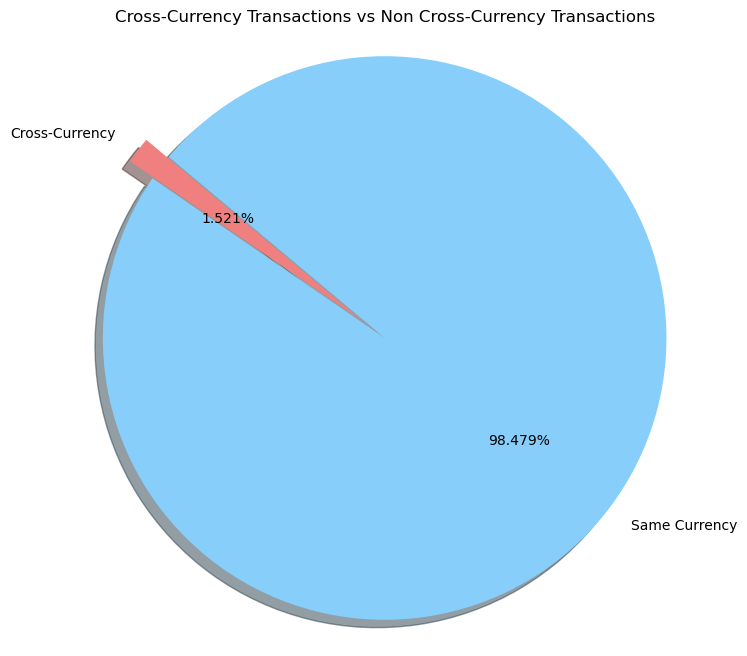

In [12]:
same_curr_L = df[df['Receiving Currency'] == df['Payment Currency']]
cross_curr_L = df[df['Receiving Currency'] != df['Payment Currency']]
same_count = len(same_curr_L)
cross_count = len(cross_curr_L)

labels = ['Cross-Currency', 'Same Currency']
sizes = [cross_count, same_count]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.3f%%', shadow=True, startangle=140)
plt.title('Cross-Currency Transactions vs Non Cross-Currency Transactions')
plt.axis('equal')
plt.show()

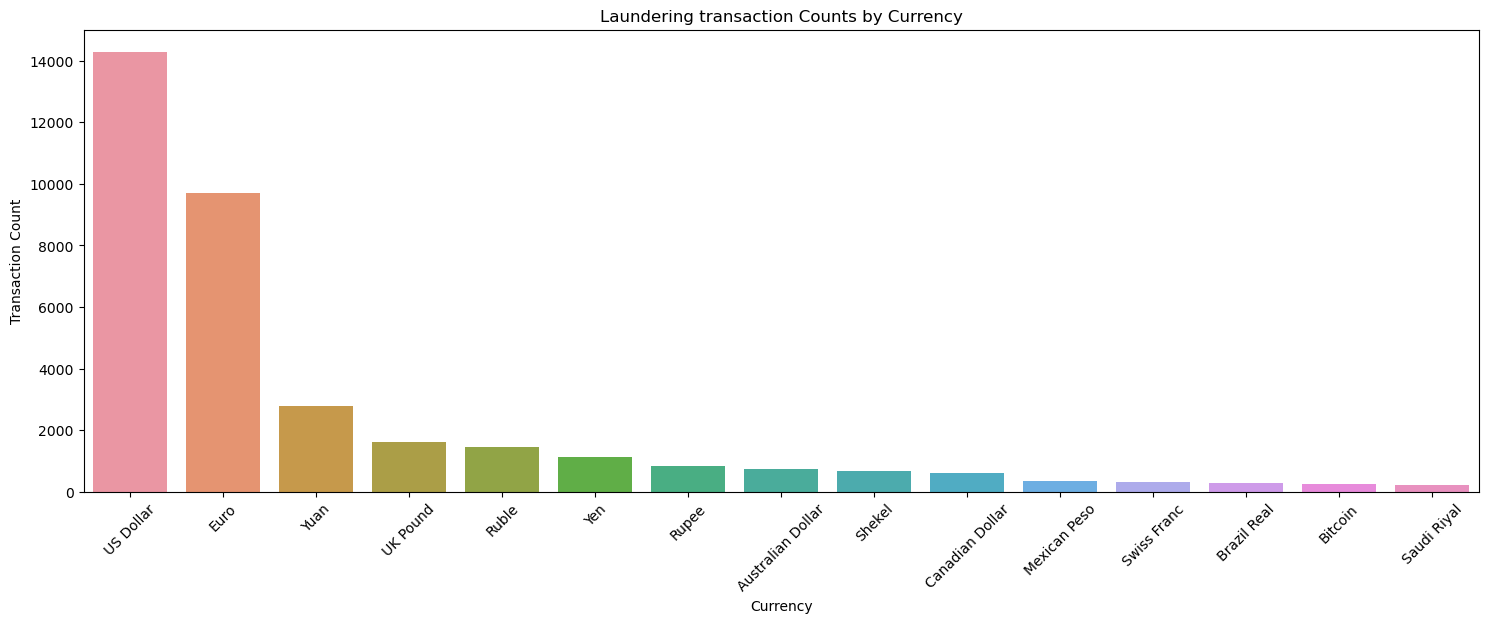

In [13]:
plt.figure(figsize=(18, 6))
sns.barplot(x='Payment Currency', y='Transaction Count', data=same_currency_L)
plt.title('Laundering transaction Counts by Currency')
plt.xlabel('Currency')
plt.ylabel('Transaction Count')
plt.xticks(rotation = 45)
plt.show()

In [14]:
# Get the payment format group
payment_formatL = Laundering.groupby('Payment Format').size().reset_index(name='Transaction Count')
payment_formatL.head()

,Payment Format,Transaction Count
0,ACH,30746
1,Bitcoin,244
2,Cash,666
3,Cheque,2220
4,Credit Card,1354


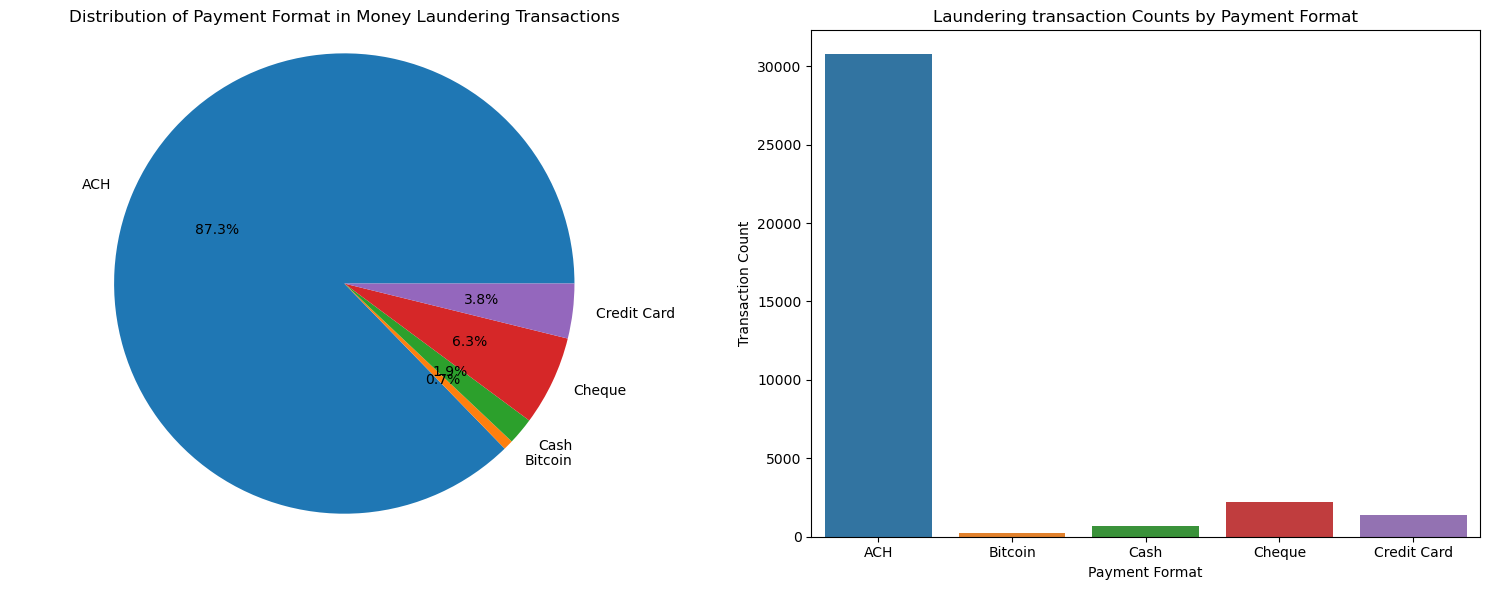

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].pie(payment_formatL['Transaction Count'], labels=payment_formatL['Payment Format'], autopct='%1.1f%%', startangle=0)
axes[0].set_title('Distribution of Payment Format in Money Laundering Transactions')
axes[0].axis('equal')


sns.barplot(x='Payment Format', y='Transaction Count', data=payment_formatL,ax=axes[1])
axes[1].set_title('Laundering transaction Counts by Payment Format')
axes[1].set_xlabel('Payment Format')
axes[1].set_ylabel('Transaction Count')
plt.tight_layout()
plt.show()

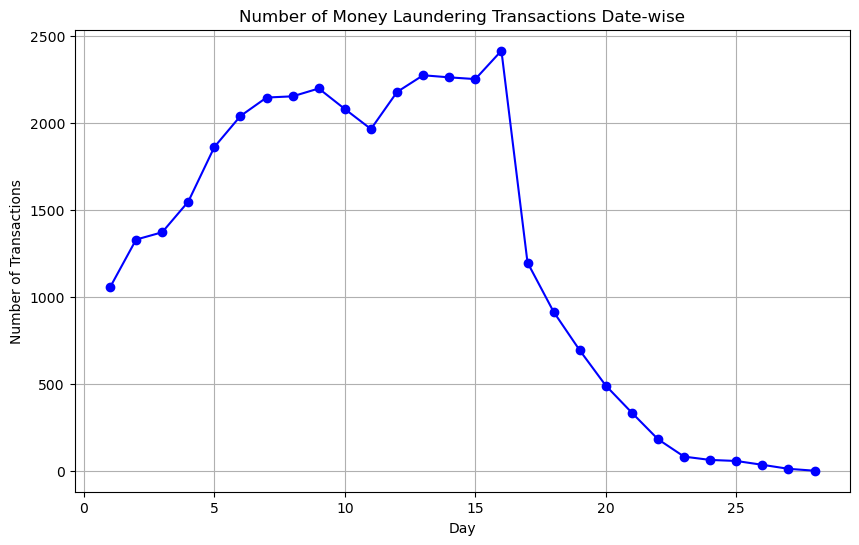

In [16]:
Laundering['Timestamp'] = pd.to_datetime(Laundering['Timestamp'])
Laundering['Day'] = Laundering['Timestamp'].dt.day
daily_transactions = Laundering.groupby('Day').size()

daily_transactions.plot(kind='line', marker='o', color='b', figsize=(10, 6))
plt.title('Number of Money Laundering Transactions Date-wise')
plt.xlabel('Day')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

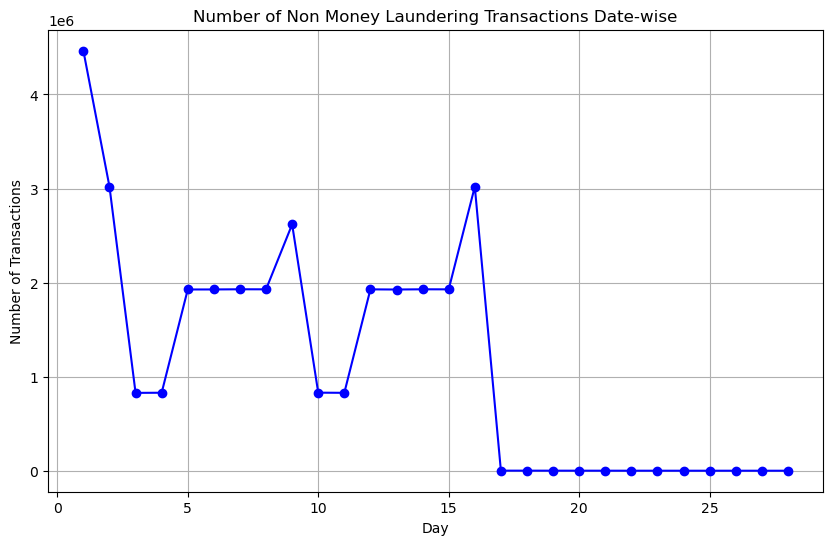

In [17]:
Non_Laundering['Timestamp'] = pd.to_datetime(Non_Laundering['Timestamp'])
Non_Laundering['Day'] = Non_Laundering['Timestamp'].dt.day
daily_transactions = Non_Laundering.groupby('Day').size()

daily_transactions.plot(kind='line', marker='o', color='b', figsize=(10, 6))
plt.title('Number of Non Money Laundering Transactions Date-wise')
plt.xlabel('Day')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

In [18]:
# Extracting year/month/day/hours/min
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day

df['Hours'] = df['Timestamp'].dt.hour
df['Minutes'] = df['Timestamp'].dt.minute

In [19]:
df.nunique()

Timestamp               26086
From Bank              122330
From account          2013627
To Bank                 62820
To account            1689925
Amount Received       2824359
Receiving Currency         15
Amount Paid           2850751
Payment Currency           15
Payment Format              7
Is Laundering               2
Year                        1
Month                       1
Day                        28
Hours                      24
Minutes                    60
dtype: int64

In [20]:
df.head()

,Timestamp,From Bank,From account,To Bank,To account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Year,Month,Day,Hours,Minutes
0,2022-09-01 00:17:00,20,800104D70,20,800104D70,6794.63,US Dollar,6794.63,US Dollar,Reinvestment,0,2022,9,1,0,17
1,2022-09-01 00:02:00,3196,800107150,3196,800107150,7739.29,US Dollar,7739.29,US Dollar,Reinvestment,0,2022,9,1,0,2
2,2022-09-01 00:17:00,1208,80010E430,1208,80010E430,1880.23,US Dollar,1880.23,US Dollar,Reinvestment,0,2022,9,1,0,17
3,2022-09-01 00:03:00,1208,80010E650,20,80010E6F0,73966883.00,US Dollar,73966883.00,US Dollar,Cheque,0,2022,9,1,0,3
4,2022-09-01 00:02:00,1208,80010E650,20,80010EA30,45868454.00,US Dollar,45868454.00,US Dollar,Cheque,0,2022,9,1,0,2


In [21]:
# We drop Timestamp we don't need it anymore
# We can see that the year and month are only one value so we can drop them to reduce dimensions
df = df.drop(columns = ['Timestamp', 'Year', 'Month'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31898218 entries, 0 to 31898237
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   From Bank           int64  
 1   From account        object 
 2   To Bank             int64  
 3   To account          object 
 4   Amount Received     float64
 5   Receiving Currency  object 
 6   Amount Paid         float64
 7   Payment Currency    object 
 8   Payment Format      object 
 9   Is Laundering       int64  
 10  Day                 int32  
 11  Hours               int32  
 12  Minutes             int32  
dtypes: float64(2), int32(3), int64(3), object(5)
memory usage: 3.0+ GB


In [22]:
# Label encoding the accounts
To_acc = LabelEncoder()
From_acc = LabelEncoder()

df['From account'] = From_acc.fit_transform(df['From account'])
df['To account'] = To_acc.fit_transform(df['To account'])

In [23]:
# Onehot encoding Payment Currency\ Payment Format\ Receiving Currency
Payment_Format_ohe = OneHotEncoder(sparse = False)
Payment_Currency_ohe = OneHotEncoder(sparse = False)
Receiving_Currency_ohe = OneHotEncoder(sparse= False)

df['Payment Currency'] = Payment_Currency_ohe.fit_transform(df[['Payment Currency']])
df['Payment Format'] = Payment_Format_ohe.fit_transform(df[['Payment Format']])
df['Receiving Currency'] = Receiving_Currency_ohe.fit_transform(df[['Receiving Currency']])

In [24]:
# Scaling all numerical features except for Amount Paid\ Amount Received
sc_FromBank = StandardScaler()
sc_Fromaccount = StandardScaler()
sc_ToBank = StandardScaler()
sc_Toaccount = StandardScaler()

# Scaling Amount Paid\ Amount Received but with quantile transformer to deal with outliers
q_amountpaid = QuantileTransformer(n_quantiles=300, output_distribution='normal')
q_amountreceived = QuantileTransformer(n_quantiles=300, output_distribution='normal')

df['From Bank'] = sc_FromBank.fit_transform(df[['From Bank']])
df['From account'] = sc_Fromaccount.fit_transform(df[['From account']])
df['To Bank'] = sc_ToBank.fit_transform(df[['To Bank']])
df['To account'] = sc_Toaccount.fit_transform(df[['To account']])

df['Amount Paid'] = q_amountpaid.fit_transform(df[['Amount Paid']])
df['Amount Received'] = q_amountreceived.fit_transform(df[['Amount Received']])

In [25]:
df.head()

,From Bank,From account,To Bank,To account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Day,Hours,Minutes
0,-0.478437,-1.099487,-0.625171,-1.707696,0.526393,0.0,0.501960,0.0,0.0,0,1,0,17
1,-0.473275,-1.099465,-0.620320,-1.707669,0.560767,0.0,0.546100,0.0,0.0,0,1,0,2
2,-0.476506,-1.099391,-0.623357,-1.707588,0.107609,0.0,0.074491,0.0,0.0,0,1,0,17
3,-0.476506,-1.099386,-0.625171,-1.707580,2.628822,0.0,2.714478,0.0,0.0,0,1,0,3
4,-0.476506,-1.099386,-0.625171,-1.707575,2.537579,0.0,2.625430,0.0,0.0,0,1,0,2


# Modeling stage

In [26]:
X = df.drop(columns = ['Is Laundering'])
Y = df['Is Laundering']

In [27]:
# Oversampling the minority data which is Laundering records
smote = SMOTE(n_jobs = -1, random_state = 42, sampling_strategy = 'minority')
X_resampled, y_resampled = smote.fit_resample(X, Y)  

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=42, shuffle = True)

In [29]:
# Using XGboost ensemble model that is powerful and can deal with imbalanced data
XGBC = XGBClassifier(device = 'gpu', n_jobs = -1, verbosity = 2, alpha = 0.001, max_leaves = 26, learning_rate = 0.01, max_depth = 26,
                     n_estimators=30)

XGBC.fit(X_train, y_train)

XGBClassifier(alpha=0.001, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=26, max_leaves=26,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=-1,
              num_parallel_tree=None, ...)

In [30]:
y_hat = XGBC.predict(X_test)

print('Accuracy score = ', round((accuracy_score(y_test, y_hat) * 100), 2), '%')

print('\n\t\t--Classification Report--')
print(classification_report(y_test, y_hat))

Accuracy score =  92.93 %

		--Classification Report--
              precision    recall  f1-score   support

           0       0.95      0.91      0.93  10514340
           1       0.91      0.95      0.93  10515233

    accuracy                           0.93  21029573
   macro avg       0.93      0.93      0.93  21029573
weighted avg       0.93      0.93      0.93  21029573



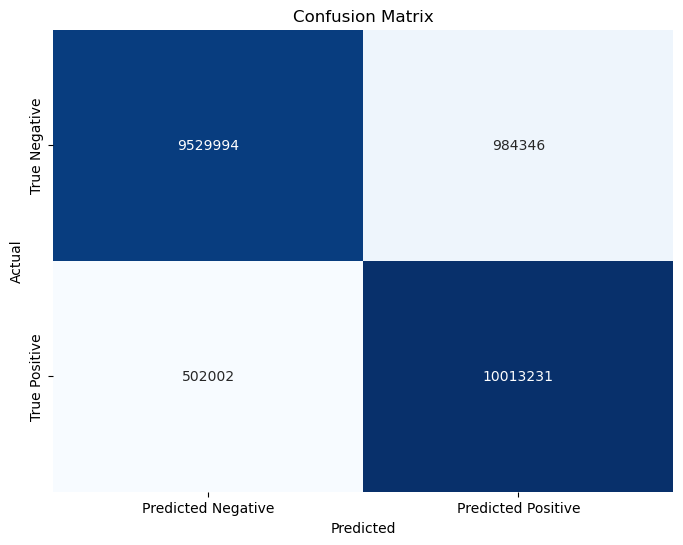

In [31]:
conf_matrix = confusion_matrix(y_test, y_hat)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [33]:
# Saving obj
pickle.dump(XGBC, open('XGBC.pkl', 'wb'))

pickle.dump(To_acc, open('To_acc.pkl', 'wb'))
pickle.dump(From_acc, open('From_acc.pkl', 'wb'))

pickle.dump(Payment_Format_ohe, open('Payment_Format_ohe.pkl', 'wb'))
pickle.dump(Payment_Currency_ohe, open('Payment_Currency_ohe.pkl', 'wb'))
pickle.dump(Receiving_Currency_ohe, open('Receiving_Currency_ohe.pkl', 'wb'))

pickle.dump(sc_FromBank, open('sc_FromBank.pkl', 'wb'))
pickle.dump(sc_Fromaccount, open('sc_Fromaccount.pkl', 'wb'))
pickle.dump(sc_ToBank, open('sc_ToBank.pkl', 'wb'))
pickle.dump(sc_Toaccount, open('sc_Toaccount.pkl', 'wb'))

pickle.dump(q_amountpaid, open('q_amountpaid.pkl', 'wb'))
pickle.dump(q_amountreceived, open('q_amountreceived.pkl', 'wb'))

pickle.dump(smote, open('smote.pkl', 'wb'))

# To load any obj:
# pickled_model = pickle.load(open('Save\XGBC.pkl', 'rb'))